In [1]:
import pandas as pd
import numpy as np

In [2]:
path_to_ground_truth = '../enamineSubset10KGroundTruth.csv'

In [3]:
ground_truth = pd.read_csv(path_to_ground_truth)

In [4]:
bace = np.array(ground_truth.bace)
logD = np.array(ground_truth.logD)
esol = np.array(ground_truth.esol)

In [5]:
# hmm: the highest BACE scores are at the beginning I think?
np.maximum.accumulate(bace)

array([5.5001307, 5.5001307, 5.5001307, ..., 5.5001307, 5.5001307,
       5.5001307])

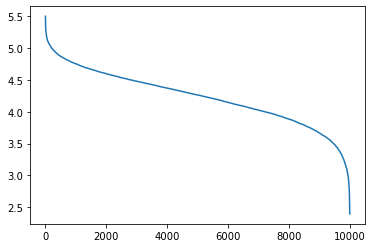

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bace)

In [7]:
inds = np.arange(len(bace))

bace_trajectories = []
for _ in range(1000):
    np.random.shuffle(inds)
    bace_trajectories.append(np.maximum.accumulate(bace[inds]))

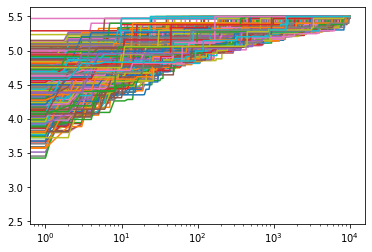

In [8]:
for traj in bace_trajectories:
    plt.plot(traj)
plt.xscale('log')

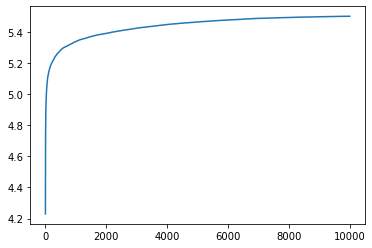

In [9]:

plt.plot(np.mean(bace_trajectories, 0))

In [10]:
help(np.percentile)

Help on function percentile in module numpy:

percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    Compute the q-th percentile of the data along the specified axis.
    
    Returns the q-th percentile(s) of the array elements.
    
    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to compute the percentile(s) along a flattened
        version of the array.
    
        .. versionchanged:: 1.9.0
            A tuple of axes is supported
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output,
     

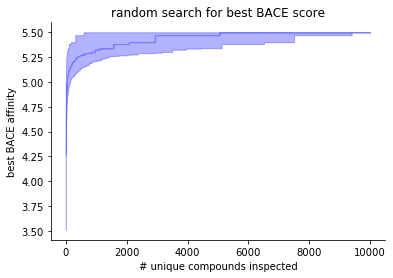

In [11]:
#eps_list = np.linspace(0,50,20)
eps_list = np.linspace(5,50,2)

ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for eps in eps_list:
    min_, max_ = np.percentile(bace_trajectories, [eps,100-eps], axis=0)
    plt.fill_between(np.arange(len(inds)), min_, max_, alpha=0.3, color='blue')
#plt.xscale('log')
plt.xlabel('# unique compounds inspected')
plt.ylabel('best BACE affinity')
plt.title('random search for best BACE score')
plt.savefig('running_best_BACE_affinity_random_search.png', dpi=300)

In [12]:
target_bounds={"bace":(4, np.inf), "esol":(-5, np.inf), "logD":(-0.4, 5.6)}
bace_range = target_bounds["bace"]
esol_range = target_bounds["esol"]
logD_range = target_bounds["logD"]


def compute_bace_score(bace):
    return np.where(bace < bace_range[0], 0.2*bace-0.8, 0.05*bace-0.2)

def compute_esol_score(esol):
    return np.where(esol < esol_range[0], esol - np.absolute(esol-esol_range[1])**2, esol)

def compute_logD_sore(logD):
    int_arr = np.where(logD < logD_range[0], logD - np.absolute(logD-logD_range[0]), logD)
    return np.where(int_arr > logD_range[1], int_arr - np.absolute(int_arr-logD_range[1]), int_arr)

def goodness(bace, esol, logD):
    return compute_bace_score(bace) + compute_esol_score(esol) + compute_logD_sore(logD)

In [13]:
inds = np.arange(len(bace))
from tqdm import tqdm
trajectories = []
for _ in tqdm(range(1000)):
    np.random.shuffle(inds)
    
    trajectories.append(np.maximum.accumulate(goodness(bace[inds], esol[inds], logD[inds])))

100%|██████████| 1000/1000 [00:00<00:00, 1575.94it/s]


(array([  15.,   50.,  203.,  638., 1493., 2544., 2818., 1771.,  431.,
          37.]),
 array([2.3942475 , 2.70483582, 3.01542414, 3.32601246, 3.63660078,
        3.9471891 , 4.25777742, 4.56836574, 4.87895406, 5.18954238,
        5.5001307 ]),
 <a list of 10 Patch objects>)

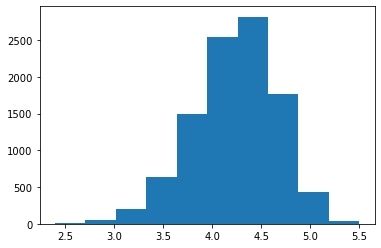

In [14]:
plt.hist(bace)

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


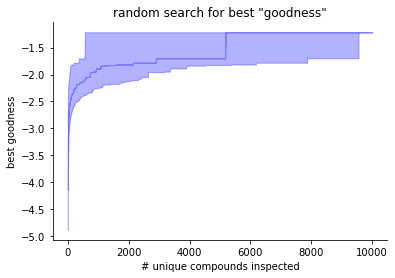

In [15]:
eps_list = np.linspace(5,50,2)
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for eps in tqdm(eps_list):
    min_, max_ = np.percentile(trajectories, [eps,100-eps], axis=0)
    plt.fill_between(np.arange(len(inds)), min_, max_, alpha=0.3, color='blue')
#plt.xscale('log')
plt.xlabel('# unique compounds inspected')
plt.ylabel('best goodness')
plt.title('random search for best "goodness"')

plt.savefig('running_best_goodness_random_search.png', dpi=300)